# M3 Reconstruction
### Using the 3 highest P_{T} jets Lorentz Vector to construct and invariant mass. Known as M3 Reconstruction
#### By Zach Shelton
#### 01/31/2021

Thank you to Danny Noonan for the NanoAOD HackSchema.

Initial Imports and Packages Below:

In [60]:
import uproot
import uproot_methods
import numpy as np
import awkward0 as ak0
import awkward1 as ak1
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
from uproot_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import awkward
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
def m3_recon(tree):
    comb= ak1.combinations(tree,n=3,axis=1,fields=['j1','j2','j3'])
    trijets= comb.j1+comb.j2+comb.j3
    recon =ak1.argmax(trijets.pt,axis=1,keepdims=True)
    reconfinal=trijets[recon]
    recomass=reconfinal.mass
    return ak1.to_numpy(ak1.flatten(recomass))
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"

In [61]:
events =NanoEventsFactory.from_root(files,schemaclass=HackSchema).events()
#events.Jet.fields

From Table 11(CMS Draft Analysis Note), the following cuts were implemented to filter out jets that meet the requirements to be a bare minimum jet that COULD be from a tt-bar pair, The assumption is that 3 highest $p_t$ jets are from the tt-bar(s)

<img src="Table11.png">

In [62]:
#There are a varying number of jets in each event. Not every event is what we are looking for:
#M3 recon chooses the 4-vectors of the jets with the 3 highest p_t
print(events.Jet)

[[Jet, Jet, Jet, Jet, Jet], [Jet, Jet, ... Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet]]


In [63]:
#From table 11, taking direct cuts.
print("No Cuts or filtering: %s" %(len(ak1.flatten(events.Jet.pt))))
non_cut= events
#no_cutsrecon=m3_recon(non_cut.Jet)

No Cuts or filtering: 13913624


In [64]:
#(ak1.count(events.Jet.pt,axis=1))
print(len(events.Jet))

1734354


In [65]:
jetSelect = ((events.Jet.pt>30) & 
             (abs(events.Jet.eta)<2.4))
goodJets = events.Jet[jetSelect]

In [66]:
print(goodJets.pt)
print(ak1.count(goodJets.pt,axis=1))

[[123, 87.9, 44.4, 36.2, 31.9], [74.4, ... [107, 78.7, 71.5, 68.1, 67.1, 32.7]]
[5, 5, 4, 4, 4, 7, 5, 4, 4, 3, 3, 4, 2, 5, ... 4, 5, 4, 5, 4, 4, 8, 5, 6, 4, 7, 4, 6]


In [67]:
#Filters out events with less than 3 Jets
goodJets=goodJets[(ak1.count(goodJets.pt,axis=1)>3)]

In [68]:
simplecuts=goodJets
print("Kinematics and B-tag descriminator: %s" %(len(ak1.flatten(goodJets.pt))))
simpcutsrecon=m3_recon(goodJets)

Kinematics and B-tag descriminator: 6730078


The data seems to be a skim of "bare minimum jets", while redundant above it's important for future datasets.

To-Do Filter for lepton events using CMS Analysis Notes

In [69]:
#Filtering out events without exactly 1 lepton

<AxesSubplot:xlabel='p_{t}', ylabel='Counts'>

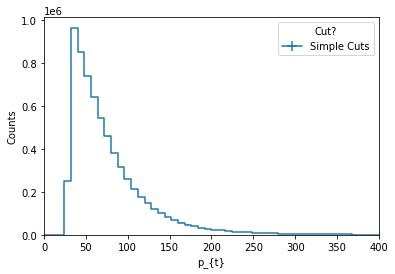

In [70]:
import coffea.hist as hist
cat=hist.Cat("cut","Cut?")
bins=hist.Bin("p_t","p_{t}",50,0,400)
histogram= hist.Hist("Counts",cat,bins)
histogram.fill(cut="Simple Cuts",p_t=ak1.flatten(simplecuts.pt))
#histogram.fill(cut="Lepton Cut",p_t=ak0.flatten(leptoncuts.Jet.pt))
hist.plot1d(histogram,overlay='cut',density=False)

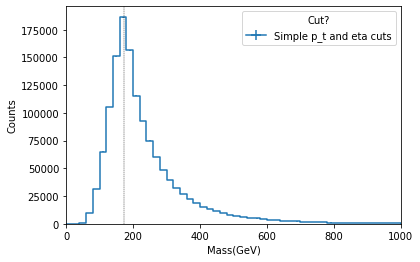

In [71]:
import matplotlib.pyplot as plt
cat=hist.Cat("cut","Cut?")
bins=hist.Bin("M3","Mass(GeV)",50,0,1000)
histogram= hist.Hist("Counts",cat,bins)
#histogram.fill(cut="Lepton Cuts",M3=postcuts_m3)
#histogram.fill(cut="No Cuts",M3=no_cutsrecon)
histogram.fill(cut="Simple p_t and eta cuts",M3=simpcutsrecon)
fig=hist.plot1d(histogram,overlay='cut',density=False)
fig.axvline(173, color='k', linestyle='dashed', linewidth=.4)

Based on the discussion Ravindra, Dr. Yumiceva and I had; the long tail of the lepton cuts is expected. But why would the data be shaped differently?

This is because jets that had a very high p_t may have had a smaller mass, and these were most likely cut out with the introduction of the lepton cuts.
Is there a kinematic reason or decay cross-section cause for this?

## What's next??
- Lepton CMS cuts
- Jet TightID
- More 
- Particle Values
- Delta R

Wrap into Coffea Executor
Seperate values, weights and triggers
read these into tensors for Keras
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
- Combine old processes together
Should I use Keras or PyTorch?


## Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

# Will be availible on Github: under username zshelton2015